In [117]:
import sounddevice as sd
from scipy.io.wavfile import write
import os
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import time
import warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)
from sklearn.preprocessing import LabelEncoder

In [23]:
def record_2_sec_voice(folder_path):
    fs = 44100
    seconds = 2 

    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype="int16")
    print("Recording Audio")
    sd.wait()  
    print("Audio recording complete")
    # sd.play(myrecording, fs)
    # sd.wait()
    # print("Play Audio Complete")
    
    num_files = len([f for f in os.listdir(folder_path)if os.path.isfile(os.path.join(folder_path, f))])
    write(folder_path + "/output" + str(num_files) + ".wav", fs, myrecording) 

In [24]:
def record_wake_word(num_files):
    path = "../data/wake_word"

    ipd.clear_output(wait=True)
    for i in tqdm(range(num_files)):
        record_2_sec_voice(path)
        print("Recorded Wake Word")
        ipd.clear_output(wait=True)
        time.sleep(1)

In [25]:
def record_not_wake_word(num_files):
    path = "../data/not_wake_word"
    
    ipd.clear_output(wait=True)
    for i in tqdm(range(num_files)):
        record_2_sec_voice(path)
        print("Recorded Not Wake Word")
        ipd.clear_output(wait=True)
        time.sleep(1)

In [26]:
record_wake_word(100)

100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


In [27]:
record_not_wake_word(100)

100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


In [2]:
wake_words = []
not_wake_words = []

for file in os.listdir("../data/wake_word"):
    if file.endswith(".wav"):
        wake_words.append("../data/wake_word/" + file)
        
for file in os.listdir("../data/not_wake_word"):
    if file.endswith(".wav"):
        not_wake_words.append("../data/not_wake_word/" + file)

In [3]:
wake_words = pd.DataFrame(wake_words, columns=["file"])
wake_words["label"] = "wake_word"

not_wake_words = pd.DataFrame(not_wake_words, columns=["file"])
not_wake_words["label"] = "not_wake_word"

In [86]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None

    return mfccsscaled, mfccs

In [87]:
def get_features(data):
    extracted_features = []
    for idx in tqdm(range(data.shape[0])):
        file_name = data["file"].iloc[idx]
        final_class_labels = data["label"].iloc[idx]
        features, mfccs = extract_features(file_name)
        extracted_features.append([features, final_class_labels])

    return extracted_features, mfccs

In [88]:
wake_word_features, wake_word_mfccs = get_features(wake_words)
not_wake_word_features, not_wake_word_mfccs = get_features(not_wake_words)

100%|██████████| 100/100 [00:01<00:00, 52.77it/s]


In [89]:
wake_word_features_df = pd.DataFrame(wake_word_features, columns=["feature", "label"])
not_wake_word_features_df = pd.DataFrame(not_wake_word_features, columns=["feature", "label"])

In [90]:
def show_mfcc(data):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(data, x_axis="time")
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()

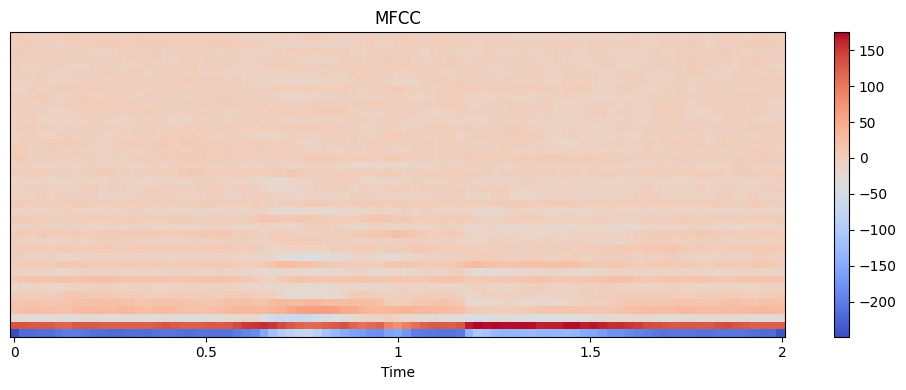

In [97]:
show_mfcc(wake_word_mfccs)

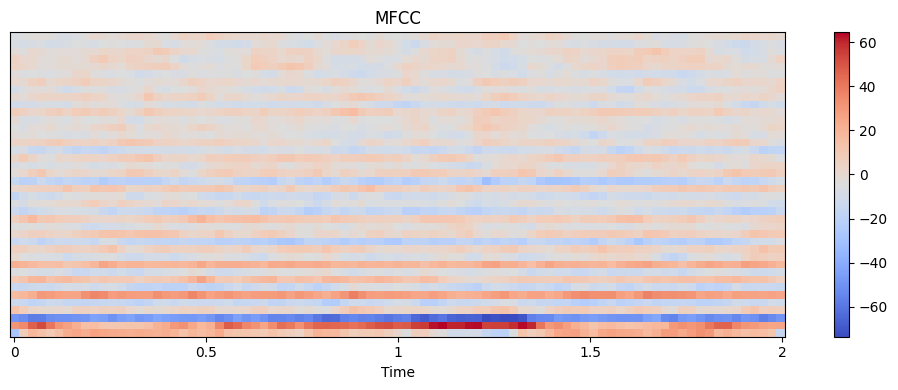

In [98]:
show_mfcc(not_wake_word_mfccs)

In [99]:
wake_word_features_df["feature"] = wake_word_features_df["feature"].apply(lambda x: x / np.max(np.abs(x)))
not_wake_word_features_df["feature"] = not_wake_word_features_df["feature"].apply(lambda x: x / np.max(np.abs(x)))

In [113]:
def add_noise(data):
    noise = 0.001 * np.random.uniform(size=len(data))
    return data + noise

def shift(data):
    return np.roll(data, 1600)

def stretch(data, rate=1):
    input_length = 1024
    data = librosa.effects.time_stretch(data, rate=rate)
    if len(data) > input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        
    return data

def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [115]:
def augment_data(data):
    augmented_data = []
    for idx in range(data.shape[0]):
        feature = data["feature"].iloc[idx]
        label = data["label"].iloc[idx]
        augmented_data.append([feature, label])
        augmented_data.append([add_noise(feature), label])
        augmented_data.append([shift(feature), label])
        augmented_data.append([stretch(feature), label])
        augmented_data.append([pitch(feature, 22050, 4), label])
    return augmented_data

In [116]:
augmented_wake_word_features_df = pd.DataFrame(augment_data(wake_word_features_df), columns=["feature", "label"])
augmented_not_wake_word_features_df = pd.DataFrame(augment_data(not_wake_word_features_df), columns=["feature", "label"])

In [123]:
augmented_wake_word_features_df["label"] = [0 for i in range(augmented_wake_word_features_df.shape[0])]
augmented_not_wake_word_features_df["label"] = [1 for i in range(augmented_not_wake_word_features_df.shape[0])]

In [124]:
augmented_wake_word_features_df

,feature,label
0,"[-1.0, 0.716109, -0.16520076, 0.1400003, 0.069...",0
1,"[-0.9995290755950477, 0.7162409479719508, -0.1...",0
2,"[-1.0, 0.716109, -0.16520076, 0.1400003, 0.069...",0
3,"[-1.0, 0.71610904, -0.16520076, 0.1400003, 0.0...",0
4,"[-0.42779946, 0.31167507, -0.051235676, 0.1141...",0
...,...,...
2495,"[-0.42004567, 0.3270358, -0.048005626, 0.11674...",0
2496,"[-0.4199158782044438, 0.3272472092924529, -0.0...",0
2497,"[-0.42004567, 0.3270358, -0.048005626, 0.11674...",0
2498,"[-0.42004567, 0.3270358, -0.04800563, 0.116740...",0


In [125]:
augmented_not_wake_word_features_df

,feature,label
0,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
1,"[-0.999144424734561, 0.6070089109167388, -0.07...",1
2,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
3,"[-1.0, 0.60646397, -0.07891267, 0.11466855, 0....",1
4,"[-0.4596668, 0.28230307, -0.016361533, 0.10313...",1
...,...,...
2495,"[0.36065993, 0.05872141, -0.5063251, 0.0748426...",1
2496,"[0.3615950619519105, 0.05880526820685671, -0.5...",1
2497,"[0.36065993, 0.05872141, -0.5063251, 0.0748426...",1
2498,"[0.36065993, 0.058721405, -0.5063251, 0.074842...",1


In [126]:
def create_model():
    model = Sequential()
    model.add(Conv1D(32, 5, activation="relu", input_shape=(40, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [127]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 32)            192       
                                                                 
 batch_normalization (BatchN  (None, 36, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            10304     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 64)           2